In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
!pip install keras_efficientnets

In [3]:
import json
import math
import os

import scipy as sp
from functools import partial
from collections import Counter
import json

import cv2
from PIL import Image
import numpy as np
from keras import backend as K
from keras import layers
from keras_efficientnets import *
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
# Image size
im_size = 256
# Batch size
BATCH_SIZE = 32

In [5]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
print(new_train.shape)
print(old_train.shape)

(3662, 2)
(35126, 2)


In [6]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()

In [7]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35126, 2)
(3662, 2)


In [8]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

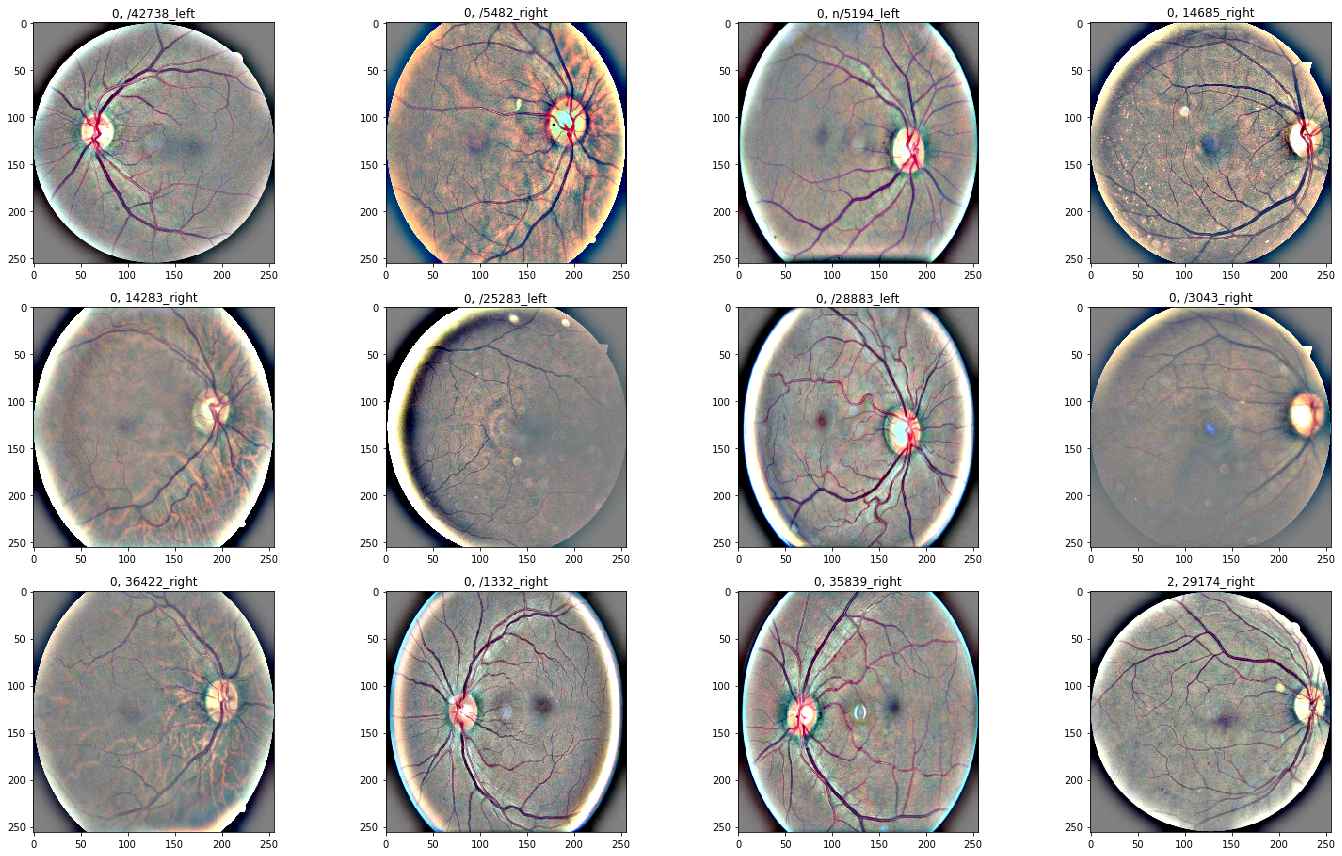

In [9]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i+50,'id_code']
        image_id = df.loc[i+50,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(f'{image_id}, {image_path[-16:-5]}')
        plt.imshow(img)
    
    plt.tight_layout()

# display train images
display_samples(train_df)

In [10]:
# train_df.iloc[35121]['id_code']

In [11]:
# # ../input/diabetic-retinopathy-resized/resized_train/resized_train/12734_right.jpeg
# pt = '../input/diabetic-retinopathy-resized/resized_train/resized_train/9351_right.jpeg'
# img = cv2.imread(pt)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (im_size,im_size))
# imgb = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
# plt.imshow(imgb)

In [12]:
# imgc = crop_image_from_gray(img)
# imgc = cv2.resize(imgc, (im_size,im_size))
# imgc = cv2.addWeighted(imgc,4,cv2.GaussianBlur(imgc, (0,0), 10) ,-4 ,128)
# plt.imshow(imgc)

In [13]:
# from keras.utils import to_categorical

y_train = train_df['diagnosis'].values
y_val = val_df['diagnosis'].values

x_train = train_df['id_code']
x_val = val_df['id_code']

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)

# y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
# y_train_multi[:, 4] = y_train[:, 4]

# for i in range(3, -1, -1):
#     y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])
    
# y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
# y_val_multi[:, 4] = y_val[:, 4]

# for i in range(3, -1, -1):
#     y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

# print("Original y_train:", y_train.sum(axis=0))
# print("Multilabel version:", y_train_multi.sum(axis=0))
# print("Original y_val:", y_val.sum(axis=0))
# print("Multilabel version:", y_val_multi.sum(axis=0))

In [14]:
# # ../input/diabetic-retinopathy-resized/resized_train/resized_train/12734_right.jpeg
# # ../input/diabetic-retinopathy-resized/resized_train/resized_train/25283_left.jpeg
# pt = '../input/diabetic-retinopathy-resized/resized_train/resized_train/25283_left.jpeg'
# # img = cv2.imread(pt)
# # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# # img = crop_image_from_gray(img)
# # img = cv2.resize(img, (im_size,im_size))
# # img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 10) ,-4 ,128)
# a = albaugment(img)
# plt.imshow(a)

In [15]:
from albumentations import *
import matplotlib.pyplot as plt

allaug = Compose([
            Rotate(p=0.7, limit=(0,360), border_mode=0,value=0), # value=black
            VerticalFlip(p=0.3),
            HorizontalFlip(p=0.3),
            RandomBrightnessContrast(brightness_limit=0.45, contrast_limit=0.45,p=0.8),
            ShiftScaleRotate(shift_limit=0, rotate_limit=0, scale_limit=(0.25, 0.25), border_mode=0, p=1)
        ], p=0.8)

def albaugment(img, aug0=allaug):
    return aug0(image=img)['image']

In [16]:
IMG_SIZE = 256

from keras.utils import Sequence

class MyGenerator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=False,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
#             img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
#             path = '../input/diabetic-retinopathy-resized/resized_train/resized_train'+sample+'.png'
            img = self.load_ben_color(sample,sigmaX=10)
#             img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = albaugment(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
#             path = '../input/aptos2019-blindness-detection/train_images/'+sample+'.png'
            img = self.load_ben_color(sample,sigmaX=10)
#             img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y
    
    def load_ben_color(self, path, sigmaX=10):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.crop_image_from_gray(image)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.addWeighted (image, 4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)        
        return image

#     def crop_image1(self, img,tol=7):
#         # img is image data
#         # tol  is tolerance    
#         mask = img>tol
#         return img[np.ix_(mask.any(1),mask.any(0))]

    def crop_image_from_gray(self, img,tol=7):
        if img.ndim ==2:
            mask = img>tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img>tol

            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0): # image is too dark so that we crop out everything,
                return img # return original image
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        #         print(img1.shape,img2.shape,img3.shape)
                img = np.stack([img1,img2,img3],axis=-1)
        #         print(img.shape)
            return img 

In [17]:
effnet = EfficientNetB3(input_shape=(IMG_SIZE,IMG_SIZE, 3), weights=None, include_top=False)
effnet.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5')

In [18]:
def build_model():
    model = Sequential()
    model.add(effnet)
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(2056))
#     model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    model.add(layers.Dense(1, activation='linear'))
    return model
model = build_model()

In [19]:
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.utils import class_weight, shuffle

epochs = 15
batch_size = 32

checkpoint = ModelCheckpoint('../working/model_checkpoint.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='auto', patience=5, verbose=1)
#lrschedule = LearningRateScheduler(schedule=, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=10)
csvlog = CSVLogger('../working/model_logs.csv', separator=',', append=True)

train_generator = MyGenerator(x_train, y_train, 32, is_train=True)
train_mixup = MyGenerator(x_train, y_train, batch_size, is_train=True, mix=True, augment=True)
valid_generator = MyGenerator(x_val, y_val, batch_size, is_train=False)

In [20]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
#         y_pred, labels = get_preds_and_labels(model, valid_generator)
        y_pred = model.predict_generator(generator=valid_generator,
                                      steps=np.ceil(float(len(y_val)) / float(batch_size)),
                                      workers=1, use_multiprocessing=True,
                                      verbose=1)
#         y_pred = y_pred.reshape((64,))
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save_weights('../working/QWK_metric_save.h5')
        return
qwk = Metrics()

In [21]:
# class Metrics(Callback):
    
#     def __init__(self, validation_data=(), batch_size=64, interval=1):
#         super(Callback, self).__init__()
#         self.interval = interval
#         self.batch_size = batch_size
#         self.valid_generator, self.y_val = validation_data
#         self.history = []
    
#     def on_train_begin(self, logs={}):
#         self.val_kappas = []

#     def on_epoch_end(self, epoch, logs={}):
#         y_pred = self.model.predict_generator(generator=self.valid_generator,
#                                               steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
#                                               workers=1, use_multiprocessing=True,
#                                               verbose=1) > 0.5

# #         X_val, y_val = self.validation_data[:2]
# #         self.y_val = self.y_val.sum(axis=1) - 1
#         y_valt = self.y_val
#         y_valt = y_valt.sum(axis=1) - 1
        
# #         y_pred = self.model.predict(X_val) > 0.5
#         y_pred = y_pred.astype(int).sum(axis=1) - 1

#         _val_kappa = cohen_kappa_score(
#             y_valt,
#             y_pred, 
#             weights='quadratic'
#         )

#         self.val_kappas.append(_val_kappa)

#         print(f"val_kappa: {_val_kappa:.4f}")
        
#         if _val_kappa == max(self.val_kappas):
#             print("Validation Kappa has improved. Saving model.")
#             self.model.save('best_QWK_model.h5')

#         return
    
# qwk = Metrics(validation_data=(valid_generator, y_val_multi),
#                     batch_size=batch_size, interval=1)

In [22]:
# import the necessary packages
from keras.callbacks import LambdaCallback
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta

        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []

        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
        
    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
        
    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
             "DataFrameIterator", "Iterator", "Sequence"]

        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses
    
    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)

        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss

        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return

        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth

        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
        
    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        verbose=1):
        # reset our class-specific variables
        self.reset()

        # determine if we are using a data generator or not
#         useGen = self.is_data_iter(trainData)
        useGen = 1

        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)

        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))

        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
            
        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch

        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)

        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))
    
        # check to see if we are using a data iterator
        if useGen:
            print('a')
            self.model.fit_generator(
                trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                verbose=verbose,
                callbacks=[callback])

        # otherwise, our entire training data is already in memory
        else:
            print('ab')
            # train our model using Keras' fit method
            self.model.fit(
                trainData[0], trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                callbacks=[callback],
                verbose=verbose)

        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)
        
    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]

        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        plt.grid()

        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8, 8, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 10,791,219
Trainable params: 10,703,923
Non-trainable params: 87,296
_________________________________________________________________


In [24]:
# for layer in model.layers:
#     layer.trainable = False

# for i in range(-3,0):
#     model.layers[i].trainable=True
    
model.compile(loss='mse', optimizer=Adam(), metrics=['mse', 'acc'])

finding learning rate...
a
Epoch 1/5
1098/1098 [==============================] - 1348s 1s/step - loss: 0.8254 - mean_squared_error: 0.8254 - acc: 0.4081
Epoch 2/5
1098/1098 [==============================] - 1328s 1s/step - loss: 0.8243 - mean_squared_error: 0.8243 - acc: 0.4075
Epoch 3/5
1098/1098 [==============================] - 1326s 1s/step - loss: 0.6734 - mean_squared_error: 0.6734 - acc: 0.3766
Epoch 4/5
1098/1098 [==============================] - 1317s 1s/step - loss: 0.7002 - mean_squared_error: 0.7002 - acc: 0.3145
Epoch 5/5
 974/1098 [=========================>....] - ETA: 2:24 - loss: 1.0255 - mean_squared_error: 1.0255 - acc: 0.2485

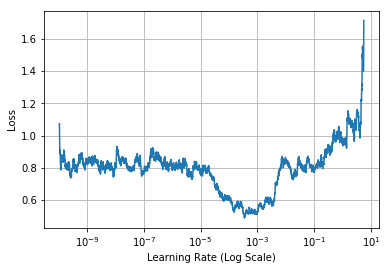

In [25]:

print("finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
    train_mixup,
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil(float(len(x_train)) / float(batch_size)),
    batchSize=32, epochs=5)
lrf.plot_loss()

In [26]:
# class WarmUpLearningRateScheduler(Callback):
#     """Warmup learning rate scheduler
#     """

#     def __init__(self, warmup_batches, init_lr, verbose=0):
#         """Constructor for warmup learning rate scheduler

#         Arguments:
#             warmup_batches {int} -- Number of batch for warmup.
#             init_lr {float} -- Learning rate after warmup.

#         Keyword Arguments:
#             verbose {int} -- 0: quiet, 1: update messages. (default: {0})
#         """

#         super(WarmUpLearningRateScheduler, self).__init__()
#         self.warmup_batches = warmup_batches
#         self.init_lr = init_lr
#         self.verbose = verbose
#         self.batch_count = 0
#         self.learning_rates = []

#     def on_batch_end(self, batch, logs=None):
#         self.batch_count = self.batch_count + 1
#         lr = K.get_value(self.model.optimizer.lr)
#         self.learning_rates.append(lr)

#     def on_batch_begin(self, batch, logs=None):
#         if self.batch_count <= self.warmup_batches:
#             lr = self.batch_count*self.init_lr/self.warmup_batches
#             K.set_value(self.model.optimizer.lr, lr)
#             if self.verbose > 0:
#                 print('\nBatch %05d: WarmUpLearningRateScheduler setting learning '
#                       'rate to %s.' % (self.batch_count + 1, lr))
                
# warmup_epoch = 5
# # Compute the number of warmup batches.
# warmup_batches = warmup_epoch * len(y_train) / 64
# warm_up_lr = WarmUpLearningRateScheduler(warmup_batches, init_lr=1e-4)

In [27]:
# WORKERS = 2

# # 5 epoch freeze training
# model.fit_generator(train_generator, steps_per_epoch=np.ceil(float(len(y_train))/float(64)), epochs=5, workers=WORKERS, use_multiprocessing=True, verbose=1,
#                   callbacks=[qwk, warm_up_lr])

In [28]:
# model.save_weights('../working/5epoch_warmup.h5')

In [29]:
# # Full train
# for layer in model.layers:
#     layer.trainable = True
    
# callbacks_list = [checkpoint, csvlog, earlystop, reducelr, qwk]

# model.compile(loss='mse', optimizer=AdamW(lr=1e-6), metrics=['mse', 'acc'])

# history = model.fit_generator(
#     train_mixup,
#     steps_per_epoch=np.ceil(float(len(x_train)) / float(batch_size)),
#     validation_data=valid_generator,
#     validation_steps=np.ceil(float(len(x_val)) / float(batch_size)),
#     epochs=20,
#     verbose=1,
#     workers=1, use_multiprocessing=False,
#     callbacks=callbacks_list)

In [30]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.show()